# Spam Classification Using Bert Tokenizer
### Aamir Hussain

- The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam.

- The files contain one message per line. Each line is composed by two columns: v1 contains the label (ham or spam) and v2 contains the raw text.

# Imports & Data Preparation

In [1]:
#pip install bert-for-tf2
#pip install sentencepiece

import pandas as pd
import numpy as np
import math
import re
import random
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import bert

print("tensorflow_version : ", tf.__version__)

tensorflow_version :  2.2.0


In [2]:
df = pd.read_csv('emails.csv')

In [76]:
df.tail()

,text,spam
5723,Subject: re : research and development charges...,0
5724,"Subject: re : receipts from visit jim , than...",0
5725,Subject: re : enron case study update wow ! a...,0
5726,"Subject: re : interest david , please , call...",0
5727,Subject: news : aurora 5 . 2 update aurora ve...,0


In [4]:
def clean_messages(message):
    message = re.sub(r"[^a-zA-Z0-1.,!?']", " ", message)
    return message

In [5]:
data_clean = [clean_messages(message) for message in df.text]

# Tokenization

In [6]:
FullTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2', trainable=False)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case)

In [7]:
def encode_sentence(sent):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sent))

In [9]:
data_inputs = [encode_sentence(sentence) for sentence in data_clean]
data_labels = df.spam.values

## Dataset Creation

We will create padded batches(so we pad sentences for each batch independently), this way we add the min of padding tokens possible. we sort sentences by length, apply padded batches and then shuffle.

In [10]:
data_with_len = [[sent, data_labels[i], len(sent)] for i , sent in enumerate(data_inputs)]
random.shuffle(data_with_len)
data_with_len.sort(key=lambda x: x[2])
sorted_all = [(sent_lab[0], sent_lab[1]) for sent_lab in data_with_len if sent_lab[2] > 2] 

In [11]:
all_dataset = tf.data.Dataset.from_generator(lambda: sorted_all, output_types=(tf.int32, tf.int32))

In [12]:
next(iter(all_dataset))

(<tf.Tensor: shape=(3,), dtype=int32, numpy=array([ 3395,  1042, 10139])>,
 <tf.Tensor: shape=(), dtype=int32, numpy=0>)

In [13]:
BATCH_SIZE = 32
all_batched = all_dataset.padded_batch(BATCH_SIZE, padded_shapes=((None, ), ()))

In [14]:
next(iter(all_batched))

(<tf.Tensor: shape=(32, 14), dtype=int32, numpy=
 array([[ 3395,  1042, 10139,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [ 3395,  2023,  7064,  3449,  5162,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [ 3395,  1012, 10147,  2546,  1012,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [ 3395,  6378,  4901, 17704,  3363,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [ 3395, 23156,  2092, 10849,  1012,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [ 3395,  2128,  2470, 16169,  4067,  2017,     0,     0,     0,
             0,     0,     0,     0,     0],
        [ 3395,  9060,  9610, 13687,  3981,  7632,     0,     0,     0,
             0,     0,     0,     0,     0],
        [ 3395,  2128, 10385,  4067,  2017,  1012,     0,     0,     0,
             0,     0,     0,     0,     0],
        [ 3395,

In [15]:
NB_BATCHES = math.ceil(len(sorted_all) / BATCH_SIZE)
NB_BATCHES_TEST = NB_BATCHES // 10
all_batched.shuffle(NB_BATCHES)
test_dataset = all_batched.take(NB_BATCHES_TEST)
train_dataset = all_batched.skip(NB_BATCHES_TEST)

# Model Building

In [53]:
VOCAB_SIZE = len(tokenizer.vocab)
EMB_DIM = 200
NB_FILTERS = 100
FFN_UNITS = 256
NB_CLASSES = 2
DROPOUT_RATE = 0.2
NB_EPOCHS = 10

In [54]:
class DCNN(tf.keras.Model):
    
    def __init__(self, vocab_size, emb_dim=128, nb_filters=50, FFN_units=512, nb_classes=2, dropout_rate=0.1, training=False, name="dcnn"):
        
        super(DCNN, self).__init__(name=name)
        
        self.embedding = layers.Embedding(vocab_size, emb_dim)
        self.bigram = layers.Conv1D(filters=nb_filters, kernel_size=2, padding="valid", activation="relu")
        self.trigram = layers.Conv1D(filters=nb_filters, kernel_size=3, padding="valid", activation="relu")
        self.fourgram = layers.Conv1D(filters=nb_filters, kernel_size=4, padding="valid", activation="relu")
        self.pool = layers.GlobalMaxPool1D()
        
        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        if nb_classes == 2:
            self.last_dense = layers.Dense(units=1, activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=nb_classes, activation="softmax")
    
    def call(self, inputs, training):
        x = self.embedding(inputs)
        x_1 = self.bigram(x) # batch_size, nb_filters, seq_len-1)
        x_1 = self.pool(x_1) # (batch_size, nb_filters)
        x_2 = self.trigram(x) # batch_size, nb_filters, seq_len-2)
        x_2 = self.pool(x_2) # (batch_size, nb_filters)
        x_3 = self.fourgram(x) # batch_size, nb_filters, seq_len-3)
        x_3 = self.pool(x_3) # (batch_size, nb_filters)
        
        merged = tf.concat([x_1, x_2, x_3], axis=-1) # (batch_size, 3 * nb_filters)
        merged = self.dense_1(merged)
        merged = self.dropout(merged, training)
        output = self.last_dense(merged)
        
        return output

In [55]:
Dcnn =  DCNN(vocab_size=VOCAB_SIZE, emb_dim=EMB_DIM, nb_filters=NB_FILTERS, 
             FFN_units=FFN_UNITS, nb_classes=NB_CLASSES, dropout_rate=DROPOUT_RATE)

In [56]:
Dcnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
r = Dcnn.fit(train_dataset, epochs=NB_EPOCHS, validation_data=test_dataset)

Epoch 1/10
162/162 [==============================] - 29s 181ms/step - loss: 0.1778 - accuracy: 0.9178 - val_loss: 0.3542 - val_accuracy: 0.8529
Epoch 2/10
162/162 [==============================] - 34s 209ms/step - loss: 0.0168 - accuracy: 0.9952 - val_loss: 0.1741 - val_accuracy: 0.9375
Epoch 3/10
162/162 [==============================] - 34s 212ms/step - loss: 0.0016 - accuracy: 0.9998 - val_loss: 0.2073 - val_accuracy: 0.9228
Epoch 4/10
162/162 [==============================] - 42s 257ms/step - loss: 3.8696e-04 - accuracy: 1.0000 - val_loss: 0.1694 - val_accuracy: 0.9430
Epoch 5/10
162/162 [==============================] - 41s 256ms/step - loss: 1.4672e-04 - accuracy: 1.0000 - val_loss: 0.1500 - val_accuracy: 0.9467
Epoch 6/10
162/162 [==============================] - 38s 232ms/step - loss: 8.5137e-05 - accuracy: 1.0000 - val_loss: 0.1487 - val_accuracy: 0.9449
Epoch 7/10
162/162 [==============================] - 52s 320ms/step - loss: 5.6116e-05 - accuracy: 1.0000 - val_loss:

# Evaluate Model

In [57]:
score = Dcnn.evaluate(test_dataset,verbose=0)
print('Test Accuracy : {:.4f} %'.format(score[1]  * 100))

Test Accuracy : 94.6691 %


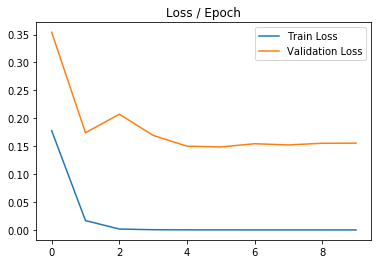

In [59]:
import matplotlib.pyplot as plt
plt.title('Loss / Epoch')
plt.plot(r.history['loss'], label='Train Loss')
plt.plot(r.history['val_loss'], label='Validation Loss')
plt.legend()

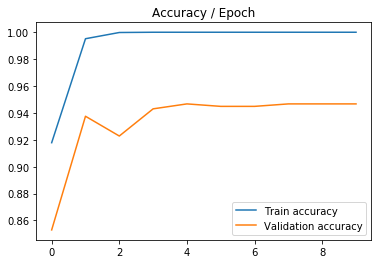

In [60]:
plt.title('Accuracy / Epoch')
plt.plot(r.history['accuracy'], label='Train accuracy')
plt.plot(r.history['val_accuracy'], label='Validation accuracy')
plt.legend()

# Making Predictions

In [83]:
def get_prediction(sentence):
    try:
        clean_mess = clean_messages(sentence)
        tokens = encode_sentence(clean_mess)
        inputs = tf.expand_dims(tokens, 0)

        output = Dcnn(inputs, training=False)

        sentiment = math.floor(output*2)

    
        if sentiment == 0:
            print("Ouput of the model: {}\nPredicted result: not spam.".format(
                output))
        elif sentiment == 1:
            print("Ouput of the model: {}\nPredicted result: spam.".format(
                output))
    except:
        return get_prediction(sentence + '.....')

In [88]:
get_prediction('Subject: aamir hussain - interview')

Ouput of the model: [[0.169834]]
Predicted result: not spam.
